In [22]:
reaction1 = 'C1CCCCC1.OO>>C1CCCCC1O'
reaction2 = 'C1CCCCC1.OO>>C1CCCCC1OO'

In [23]:
from rdkit import Chem
def assign_atom_mapping(smiles_reaction):
    try:
        reactants, products = smiles_reaction.split('>>')
        reactant_smiles = reactants.split('.')
        reactant_mols = [Chem.MolFromSmiles(r) for r in reactant_smiles]
        
        atom_map_num = 1  # Start numbering from 1 and increment globally
        for mol in reactant_mols:
            if mol:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(atom_map_num)
                    atom_map_num += 1  # Increment for each atom globally
        
        mapped_reactants = '.'.join([Chem.MolToSmiles(mol, canonical=False) for mol in reactant_mols if mol])
        mapped_reaction = f"{mapped_reactants}>>{products}"
        
        return mapped_reaction
    except Exception as e:
        return f"Error processing reaction: {e}"

In [24]:
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            raise ValueError("Invalid SMILES input.")
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        return f"Error: {e}"
    
def canonicalize_reaction(smiles_reaction):
    try:
        reactants, products = smiles_reaction.split('>>')
        canonical_reactants = '.'.join(sorted([canonicalize_smiles(r) for r in reactants.split('.')]))
        canonical_products = '.'.join(sorted([canonicalize_smiles(p) for p in products.split('.')]))
        return f"{canonical_reactants}>>{canonical_products}"
    except Exception as e:
        return f"Error: {e}"

In [25]:
from rxnmapper import RXNMapper
print(reaction1, reaction2)
rxn_mapper = RXNMapper()
results = rxn_mapper.get_attention_guided_atom_maps([canonicalize_reaction(reaction1), canonicalize_reaction(reaction2)])
[i['mapped_rxn'] for i in results]

AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the eager attention implementation, but specifying the eager implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the eager attention implementation, but specifying the eager implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embeddi

C1CCCCC1.OO>>C1CCCCC1O C1CCCCC1.OO>>C1CCCCC1OO


['[CH2:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1.O[OH:1]>>[OH:1][CH:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1',
 '[CH2:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1.[OH:1][OH:2]>>[OH:1][O:2][CH:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1']

In [26]:
assign_atom_mapping(canonicalize_reaction(reaction1))

'[CH2:1]1[CH2:2][CH2:3][CH2:4][CH2:5][CH2:6]1.[OH:7][OH:8]>>OC1CCCCC1'

In [27]:
import numpy as np
def map_atom_mappings(nativesmiles, smiles2):
    try:
        print(canonicalize_smiles(smiles2.split('>>')[0]))
        mol2 = Chem.MolFromSmiles()
        
        if not mol2:
            raise ValueError("Invalid SMILES input.")
        
        mapping_dict = {}

        
        atoms2 = [atom.GetAtomMapNum() for atom in mol2.GetAtoms() if atom.GetAtomMapNum()]
        atoms1 = np.arange(1, mol2.GetNumAtoms()+1)
        print(atoms1, atoms2)

        for idx, i in enumerate(atoms1):
            print(i, atoms2[idx])
            mapping_dict[i] = atoms2[idx]
        
        return mapping_dict
    except Exception as e:
        return {"error": str(e)}

In [28]:
map_atom_mappings('[CH3:1][CH2:2][OH:3].[CH:4](=[O:5])[Cl:6]', '[CH3:1][CH2:2][OH:3].Cl[CH:4]=[O:6]>>[CH3:1][CH2:2][O:3][C:4]([CH3:5])=[O:6]')

Cl[CH:4]=[O:6].[CH3:1][CH2:2][OH:3]


{'error': 'Python argument types in\n    rdkit.Chem.rdmolfiles.MolFromSmiles()\ndid not match C++ signature:\n    MolFromSmiles(boost::python::api::object SMILES, bool sanitize=True, boost::python::dict replacements={})\n    MolFromSmiles(boost::python::api::object SMILES, RDKit::v1::SmilesParserParams params)'}

In [29]:
def complete_atom_mapping(smiles):
    reactants, products = smiles.split(">>")
    
    molecules = reactants.split('.') + products.split('.')
    
    highest_map = 0
    for mol in molecules:
        parsed_mol = Chem.MolFromSmiles(mol)
        if parsed_mol is not None:
            for atom in parsed_mol.GetAtoms():
                map_num = atom.GetAtomMapNum()
                if map_num > highest_map:
                    highest_map = map_num
    
    new_map_num = highest_map + 1
    updated_molecules = []
    for mol in molecules:
        parsed_mol = Chem.MolFromSmiles(mol)
        if parsed_mol is not None:
            for atom in parsed_mol.GetAtoms():
                if atom.GetAtomMapNum() == 0:
                    atom.SetAtomMapNum(new_map_num)
                    new_map_num += 1
            updated_molecules.append(Chem.MolToSmiles(parsed_mol))
    
    updated_reactants = '.'.join(updated_molecules[:len(reactants.split('.'))])
    updated_products = '.'.join(updated_molecules[len(reactants.split('.')):])
    return f"{updated_reactants}>>{updated_products}"

In [33]:
from preprocess import consistent_mapping
reaction1 = complete_atom_mapping('[CH2:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1.O[OH:1]>>[OH:1][CH:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1')
reaction2 =  '[CH2:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1.[OH:1][OH:2]>>[OH:1][O:2][CH:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1'
reaction3 = '[CH2:26]1[CH2:27][CH2:28][O:29][CH2:30]1.[CH3:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH3:37].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1'
reaction4 = '[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1'
consistent_mapping([reaction3, reaction4])

({1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25}, 25)
({1: 50, 2: 51, 3: 52, 4: 53, 5: 54, 6: 55, 7: 56, 8: 57, 9: 58, 10: 59, 11: 60, 12: 61, 13: 62, 14: 63, 15: 64, 16: 65, 17: 66, 18: 67, 19: 68, 20: 69, 21: 70, 22: 71, 23: 72, 24: 73}, 73)


('[CH2:45]1[CH2:46][CH2:47][O:48][CH2:49]1.[CH3:18][c:19]1[cH:20][cH:21][c:22]([N:23]2[CH2:24][CH2:25][N:26]([C:27](=[O:28])[O:29][c:30]3[cH:31][cH:32][c:33]([N+:34](=[O:35])[O-:36])[cH:37][cH:38]3)[CH2:39][CH2:40]2)[cH:41][cH:42]1.[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH3:7].[H-:43].[Na+:44].[OH:8][CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1',
 ['[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1)[C:27]([N:26]1[CH2:25][CH2:24][N:23]([c:22]2[cH:21][cH:20][c:19]([CH3:18])[cH:42][cH:41]2)[CH2:40][CH2:39]1)=[O:28]',
  '[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][NH:14][CH2:16][CH2:17]1)[C:27]([N:26]1[CH2:25][CH2:24][N:23]([c:22]2[cH:21][cH:20][c:19]([CH3:18])[cH:42][cH:41]2)[CH2:40][CH2:39]1)=[O:28]'],
 '[CH2:45]1[CH2:46][CH2:47][O:48][CH2:49]1.[CH3:18][c:19]1[cH:20][cH:21][c:22]([N:23]2[CH2:24][CH2:25][N:26]([C:27](=[O:28])[O:29][c:30]3[cH:31][cH:32][c:33]([N+:34](=[O:35])[O-:36])[cH:37][cH:38]3)[CH2:39][CH2:40]2)[cH:41][cH:4

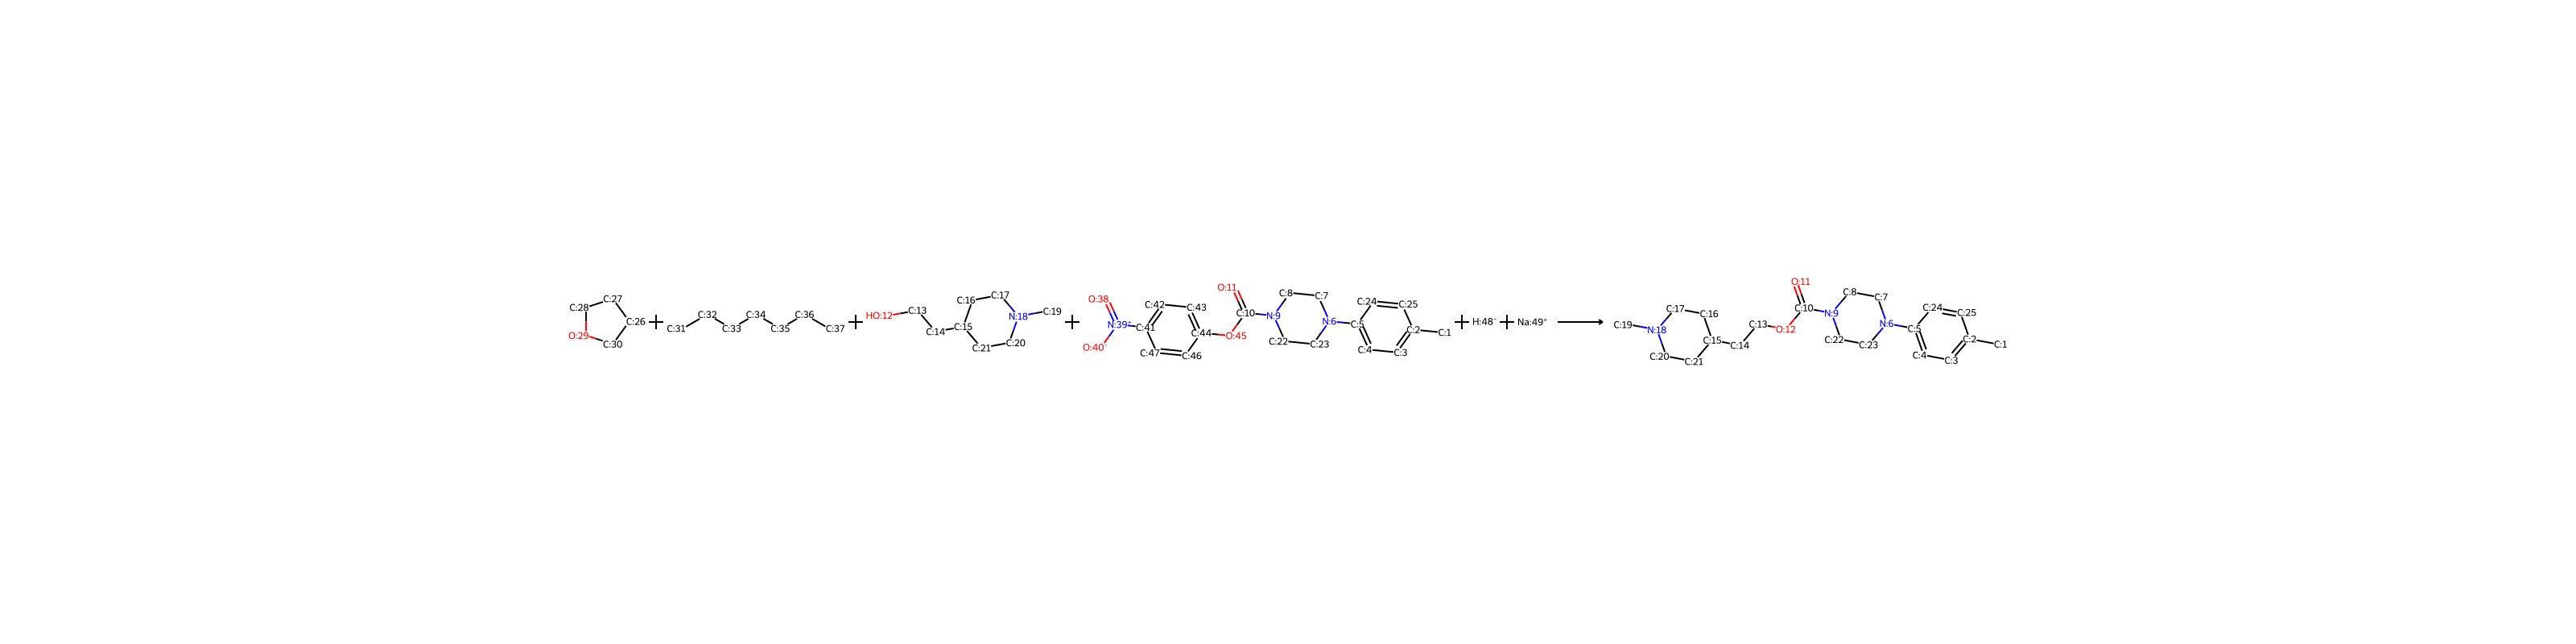

In [38]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
reaction = rdChemReactions.ReactionFromSmarts('[CH2:26]1[CH2:27][CH2:28][O:29][CH2:30]1.[CH3:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH3:37].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1', useSmiles=True)
display(Draw.ReactionToImage(reaction, subImgSize=(400, 800)))

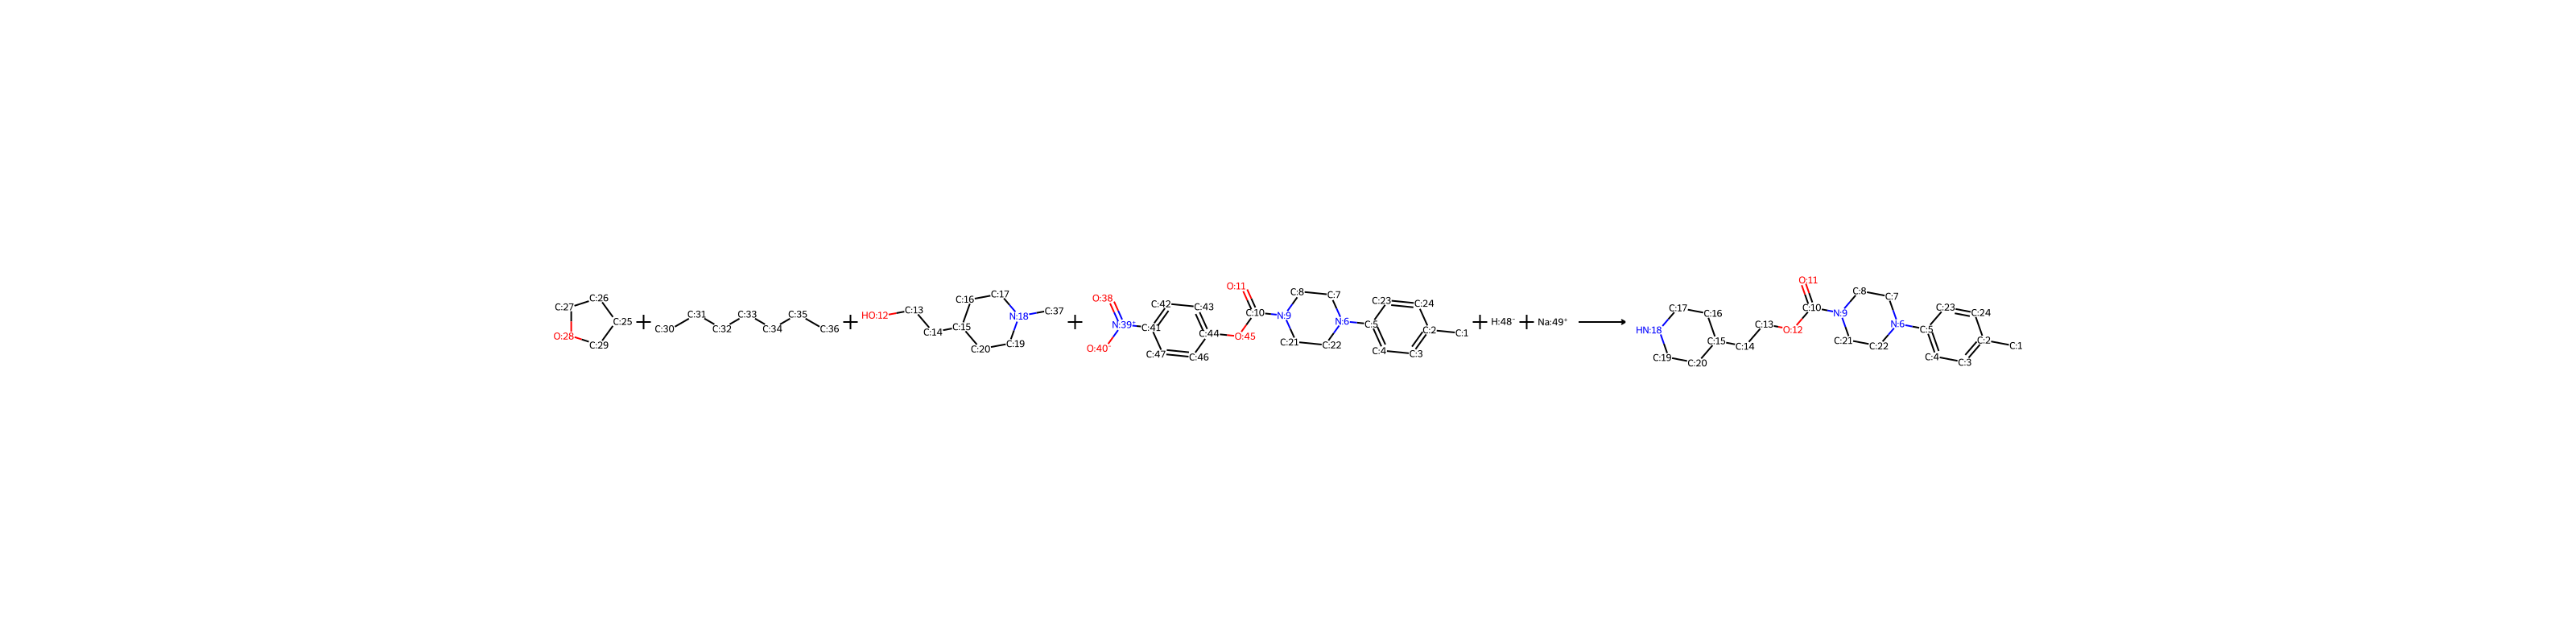

In [39]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
reaction = rdChemReactions.ReactionFromSmarts('[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1', useSmiles=True)
display(Draw.ReactionToImage(reaction, subImgSize=(400, 800)))

In [43]:
from utils import unmap_smiles

unmap_smiles('[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1')

'C1CCOC1.CCCCCCC.CN1CCC(CCO)CC1.Cc1ccc(N2CCN(C(=O)Oc3ccc([N+](=O)[O-])cc3)CC2)cc1.[H-].[Na+]>Cc1ccc(N2CCN(C(=O)OCCC3CCNCC3)CC2)cc1'

In [8]:
from utils import get_multi
from preprocess import consistent_mapping


sets = get_multi('tinyfile.txt.proc')
consistent_mapping(sets[0])[2]

({1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25}, 25)
({1: 50, 2: 51, 3: 52, 4: 53, 5: 54, 6: 55, 7: 56, 8: 57, 9: 58, 10: 59, 11: 60, 12: 61, 13: 62, 14: 63, 15: 64, 16: 65, 17: 66, 18: 67, 19: 68, 20: 69, 21: 70, 22: 71, 23: 72, 24: 73}, 73)


'[CH2:1]1[CH2:2][CH2:3][O:4][CH2:5]1.[CH3:16][c:17]1[cH:18][cH:19][c:20]([N:21]2[CH2:22][CH2:23][N:24]([C:25](=[O:26])[O:27][c:28]3[cH:29][cH:30][c:31]([N+:32](=[O:33])[O-:34])[cH:35][cH:36]3)[CH2:37][CH2:38]2)[cH:39][cH:40]1.[CH3:43][CH2:44][CH2:45][CH2:46][CH2:47][CH2:48][CH3:49].[H-:41].[Na+:42].[OH:6][CH2:7][CH2:8][CH:9]1[CH2:10][CH2:11][N:12]([CH3:13])[CH2:14][CH2:15]1>>[O:6]([CH2:7][CH2:8][CH:9]1[CH2:10][CH2:11][N:12]([CH3:13])[CH2:14][CH2:15]1)[C:25]([N:24]1[CH2:23][CH2:22][N:21]([c:20]2[cH:19][cH:18][c:17]([CH3:16])[cH:40][cH:39]2)[CH2:38][CH2:37]1)=[O:26].[O:6]([CH2:7][CH2:8][CH:9]1[CH2:10][CH2:11][NH:12][CH2:14][CH2:15]1)[C:25]([N:24]1[CH2:23][CH2:22][N:21]([c:20]2[cH:19][cH:18][c:17]([CH3:16])[cH:40][cH:39]2)[CH2:38][CH2:37]1)=[O:26]'